In [27]:
import logging
from timeit import default_timer
from typing import List, Optional, Tuple
import pandas as pd

import numpy as np

from python_tsp.heuristics.perturbation_schemes import neighborhood_gen
from python_tsp.heuristics.local_search import setup
from python_tsp.utils import compute_permutation_distance


logger = logging.getLogger(__name__)
ch = logging.StreamHandler()
ch.setLevel(level=logging.WARNING)
logger.addHandler(ch)


def solve_tsp_simulated_annealing(
    distance_matrix: np.ndarray,
    x0: Optional[List[int]] = None,
    perturbation_scheme: str = "two_opt",
    alpha: float = 0.9,
    max_processing_time: float = None,
    log_file: Optional[str] = None,
) -> Tuple[List, float]:
    """Solve a TSP problem using a Simulated Annealing
    The approach used here is the one proposed in [1].

    Parameters
    ----------
    distance_matrix
        Distance matrix of shape (n x n) with the (i, j) entry indicating the
        distance from node i to j

    x0
        Initial permutation. If not provided, it starts with a random path

    perturbation_scheme {"ps1", "ps2", "ps3", "ps4", "ps5", "ps6", ["two_opt"]}
        Mechanism used to generate new solutions. Defaults to "two_opt"

    alpha
        Reduction factor (``alpha`` < 1) used to reduce the temperature. As a
        rule of thumb, 0.99 takes longer but may return better solutions, whike
        0.9 is faster but may not be as good. A good approach is to use 0.9
        (as default) and if required run the returned solution with a local
        search.

    max_processing_time {None}
        Maximum processing time in seconds. If not provided, the method stops
        only when there were 3 temperature cycles with no improvement.

    log_file
        If not `None`, creates a log file with details about the whole
        execution

    Returns
    -------
    A permutation of nodes from 0 to n - 1 that produces the least total
    distance obtained (not necessarily optimal).

    The total distance the returned permutation produces.

    References
    ----------
    [1] Dréo, Johann, et al. Metaheuristics for hard optimization: methods and
    case studies. Springer Science & Business Media, 2006.
    """

    x, fx = setup(distance_matrix, x0)
    temp = _initial_temperature(distance_matrix, x, fx, perturbation_scheme)
    max_processing_time = max_processing_time or np.inf
    if log_file:
        fh = logging.FileHandler(log_file)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
        logger.setLevel(logging.INFO)

    n = len(x)
    k_inner_min = n  # min inner iterations
    k_inner_max = 10 * n  # max inner iterations
    k_noimprovements = 0  # number of inner loops without improvement

    tic = default_timer()
    stop_early = False
    while (k_noimprovements < 3) and (not stop_early):
        k_accepted = 0  # number of accepted perturbations
        for k in range(k_inner_max):
            if default_timer() - tic > max_processing_time:
                logger.warning("Stopping early due to time constraints")
                stop_early = True
                break

            xn = _perturbation(x, perturbation_scheme)
            fn = compute_permutation_distance(distance_matrix, xn)

            if _acceptance_rule(fx, fn, temp):
                x, fx = xn, fn
                k_accepted += 1
                k_noimprovements = 0

            logger.info(
                f"Temperature {temp}. Current value: {fx} "
                f"k: {k + 1}/{k_inner_max} "
                f"k_accepted: {k_accepted}/{k_inner_min} "
                f"k_noimprovements: {k_noimprovements}"
            )

            if k_accepted >= k_inner_min:
                break

        temp *= alpha  # temperature update
        k_noimprovements += k_accepted == 0

    return x, fx


def _initial_temperature(
    distance_matrix: np.ndarray,
    x: List[int],
    fx: float,
    perturbation_scheme: str,
) -> float:
    """Compute initial temperature
    Instead of relying on problem-dependent parameters, this function estimates
    the temperature using the suggestion in [1].

    Notes
    -----
    Here are the steps followed:
        1. Generate 100 disturbances at random from T0, and evaluate the mean
        objective value differences dfx_mean = mean(fn - fx);
        2. Choose tau0 = 0.5 as assumed quality of initial solution (assuming
        a bad one), and deduce T0 from exp(-fx_mean/T0) = tau0, that is,
        T0 = -fx_mean/ln(tau0)

    References
    ----------
    [1] Dréo, Johann, et al. Metaheuristics for hard optimization: methods and
    case studies. Springer Science & Business Media, 2006.
    """

    # Step 1
    dfx_list = []
    for _ in range(100):
        xn = _perturbation(x, perturbation_scheme)
        fn = compute_permutation_distance(distance_matrix, xn)
        dfx_list.append(fn - fx)

    dfx_mean = np.abs(np.mean(dfx_list))

    # Step 2
    tau0 = 0.5
    return -dfx_mean / np.log(tau0)


def _perturbation(x: List[int], perturbation_scheme: str):
    """Generate a random neighbor of a current solution ``x``
    In this case, we can use the generators created in the `local_search`
    module, and pick the first solution. Since the neighborhood is randomized,
    it is the same as creating a random perturbation.
    """
    return next(neighborhood_gen[perturbation_scheme](x))


def _acceptance_rule(fx: float, fn: float, temp: float) -> bool:
    """Metropolis acceptance rule"""

    dfx = fn - fx
    return (dfx < 0) or (
        (dfx > 0) and (np.random.rand() <= np.exp(-(fn - fx) / temp))
    )

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

In [29]:
# df = pd.read_csv("위경도좌표.csv", encoding='cp949')
# sns.set(style='whitegrid', font='KoPubDotum', font_scale=1.2)

In [30]:
df = pd.read_excel("../1.데이터/20230323_clustering.xlsx")
# print(df.iloc[:10,[2,1]].values)
# df=df.iloc[:,[1,2]].values
# df

In [31]:
X = df.iloc[:,[2]].values
Y = df.iloc[:,[1]].values
Z = np.hstack([X,Y])

In [32]:
len(Z)

50

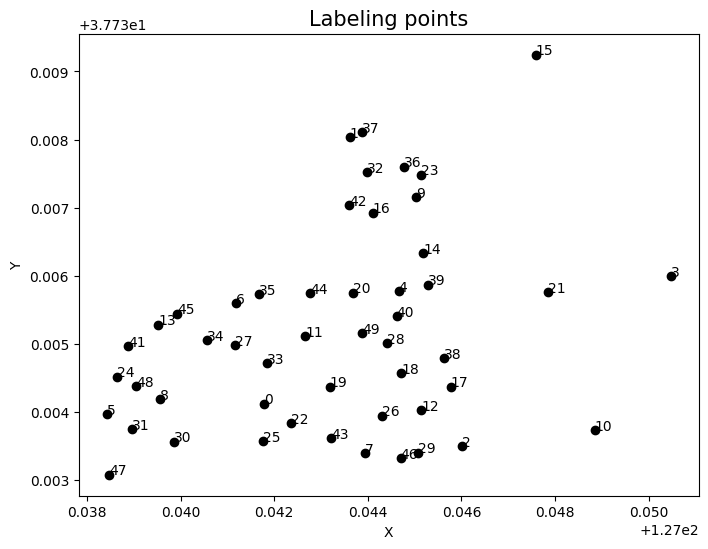

In [33]:
annotations=[]
for i in range(len(Z)):
    annotations.append(str(i))

plt.figure(figsize=(8,6))
plt.scatter(X,Y,color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Labeling points",fontsize=15)
for i, label in enumerate(annotations):
    plt.text(X[i], Y[i],label)

plt.show()

In [34]:
# df = pd.read_csv('cluster(GMM) - clus 주기사.csv')
# #df = df.drop(columns = ['Unnamed: 0'])
# #df
# df = df.to_numpy()
# #df

In [35]:
df = df.iloc[:,1:3]

In [36]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

def maker(df):
    Z = df.iloc[:,[1]].values
    Y = df.iloc[:,[0]].values
    X = np.hstack([Z,Y])

    X_cdist_cityblock = distance.cdist(X, X, metric='cityblock')


    return X_cdist_cityblock


In [37]:
a = maker(df)
a

array([[0.        , 0.0057422 , 0.00486286, ..., 0.0043409 , 0.00298864,
        0.00314007],
       [0.0057422 , 0.        , 0.0069362 , ..., 0.0100831 , 0.0082131 ,
        0.00315167],
       [0.00486286, 0.0069362 , 0.        , ..., 0.00794795, 0.0078515 ,
        0.00378453],
       ...,
       [0.0043409 , 0.0100831 , 0.00794795, ..., 0.        , 0.00187   ,
        0.00748097],
       [0.00298864, 0.0082131 , 0.0078515 , ..., 0.00187   , 0.        ,
        0.00561097],
       [0.00314007, 0.00315167, 0.00378453, ..., 0.00748097, 0.00561097,
        0.        ]])

In [38]:
result = solve_tsp_simulated_annealing(
    distance_matrix= a,
    perturbation_scheme= "two_opt",
    alpha= 0.9,
        max_processing_time = None)

In [39]:
result = result[:-1]
result

([0,
  22,
  11,
  44,
  20,
  42,
  1,
  37,
  32,
  16,
  9,
  23,
  36,
  15,
  21,
  3,
  10,
  2,
  17,
  38,
  39,
  14,
  4,
  40,
  49,
  28,
  18,
  26,
  12,
  29,
  46,
  7,
  43,
  19,
  33,
  35,
  6,
  27,
  34,
  45,
  13,
  41,
  24,
  5,
  47,
  31,
  48,
  8,
  30,
  25],)

In [40]:
add = []
for i in result:
    add.append(i)
add
sequence = []

for i in range(len(add[0])):
    for j, k in enumerate(add[0]):
        # print(k,i)
        if i == k:
            sequence.append(j)
sequence
            

[0,
 6,
 17,
 15,
 22,
 43,
 36,
 31,
 47,
 10,
 16,
 2,
 28,
 40,
 21,
 13,
 9,
 18,
 26,
 33,
 4,
 14,
 1,
 11,
 42,
 49,
 27,
 37,
 25,
 29,
 48,
 45,
 8,
 34,
 38,
 35,
 12,
 7,
 19,
 20,
 23,
 41,
 5,
 32,
 3,
 39,
 30,
 44,
 46,
 24]

In [46]:
FullPoints = []
# print(float(X[1]),float(Y[1]))
for i in range(len(X)):
    FullPoints.append([float(X[i]), float(Y[i])])
FullPoints = np.array(FullPoints)
FullPoints

array([[127.04177597,  37.73412353],
       [127.0436104 ,  37.7380313 ],
       [127.04601093,  37.73349563],
       [127.0504666 ,  37.7359981 ],
       [127.0446557 ,  37.73577546],
       [127.0384281 ,  37.7339681 ],
       [127.04118784,  37.73559542],
       [127.04393994,  37.73339692],
       [127.03957087,  37.73418455],
       [127.04503698,  37.7371553 ],
       [127.04884693,  37.73373657],
       [127.04266435,  37.73510938],
       [127.045142  ,  37.73402217],
       [127.03951976,  37.7352816 ],
       [127.04518707,  37.73632763],
       [127.0475838 ,  37.7392456 ],
       [127.04410226,  37.73692827],
       [127.0457732 ,  37.73436915],
       [127.04471707,  37.73457212],
       [127.0431843 ,  37.7343685 ],
       [127.04368066,  37.73574896],
       [127.047849  ,  37.7357597 ],
       [127.04235828,  37.73383888],
       [127.04514418,  37.73748528],
       [127.03865142,  37.73452072],
       [127.04175927,  37.73356817],
       [127.04430738,  37.73394584],
 

In [64]:
path_indices = []
for i in result:
    for j in i:
        path_indices.append(j)
print(path_indices)
# path_indices = path_indices.astype(np.int32)
path_indeices = np.array(path_indices)
path_indeices

[0, 22, 11, 44, 20, 42, 1, 37, 32, 16, 9, 23, 36, 15, 21, 3, 10, 2, 17, 38, 39, 14, 4, 40, 49, 28, 18, 26, 12, 29, 46, 7, 43, 19, 33, 35, 6, 27, 34, 45, 13, 41, 24, 5, 47, 31, 48, 8, 30, 25]


array([ 0, 22, 11, 44, 20, 42,  1, 37, 32, 16,  9, 23, 36, 15, 21,  3, 10,
        2, 17, 38, 39, 14,  4, 40, 49, 28, 18, 26, 12, 29, 46,  7, 43, 19,
       33, 35,  6, 27, 34, 45, 13, 41, 24,  5, 47, 31, 48,  8, 30, 25])

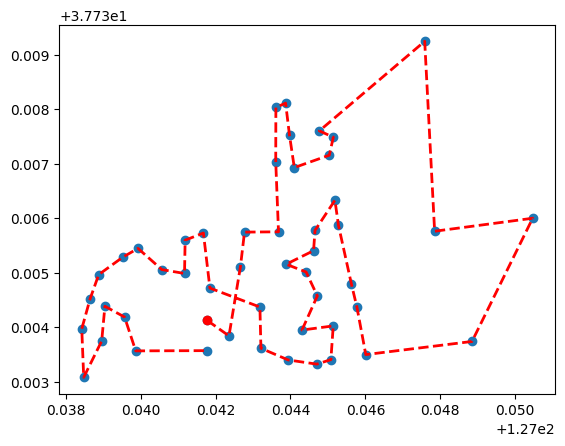

In [65]:
plt.figure()
plt.scatter(FullPoints[path_indices,0], FullPoints[path_indices,1])
plt.plot(FullPoints[path_indices,0], FullPoints[path_indices,1], 'r--', lw=2)
plt.plot(FullPoints[path_indices[0],0], FullPoints[path_indices[0],1], 'ro')

In [140]:
sequences = []
for i in sequence:
    sequences.append([i])
sequences

[[0],
 [23],
 [13],
 [15],
 [28],
 [42],
 [36],
 [5],
 [46],
 [19],
 [14],
 [34],
 [8],
 [38],
 [26],
 [17],
 [25],
 [12],
 [10],
 [3],
 [32],
 [16],
 [2],
 [18],
 [41],
 [1],
 [9],
 [48],
 [30],
 [7],
 [45],
 [44],
 [21],
 [49],
 [47],
 [35],
 [20],
 [22],
 [11],
 [27],
 [29],
 [39],
 [24],
 [4],
 [33],
 [37],
 [6],
 [43],
 [40],
 [31]]

In [141]:
asdf = np.hstack([X,Y,sequences])
asdf

array([[127.04177597,  37.73412353,   0.        ],
       [127.0436104 ,  37.7380313 ,  23.        ],
       [127.04601093,  37.73349563,  13.        ],
       [127.0504666 ,  37.7359981 ,  15.        ],
       [127.0446557 ,  37.73577546,  28.        ],
       [127.0384281 ,  37.7339681 ,  42.        ],
       [127.04118784,  37.73559542,  36.        ],
       [127.04393994,  37.73339692,   5.        ],
       [127.03957087,  37.73418455,  46.        ],
       [127.04503698,  37.7371553 ,  19.        ],
       [127.04884693,  37.73373657,  14.        ],
       [127.04266435,  37.73510938,  34.        ],
       [127.045142  ,  37.73402217,   8.        ],
       [127.03951976,  37.7352816 ,  38.        ],
       [127.04518707,  37.73632763,  26.        ],
       [127.0475838 ,  37.7392456 ,  17.        ],
       [127.04410226,  37.73692827,  25.        ],
       [127.0457732 ,  37.73436915,  12.        ],
       [127.04471707,  37.73457212,  10.        ],
       [127.0431843 ,  37.73436